# MoReS version (Keras Embedding of size 100)

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
np.random.seed(1337)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Bidirectional, Embedding, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

[nltk_data] Downloading package stopwords to /Users/ritz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ritz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ritz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data Loading and Analysis

In [237]:
train_data = pd.read_csv('Data/train.tsv', sep = '\t')
test_data = pd.read_csv('Data/test.tsv', sep = '\t')

In [238]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [239]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [240]:
Sentiment_words = []
for row in train_data['Sentiment']:
    if row == 0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
train_data['Sentiment_words'] = Sentiment_words

In [241]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [242]:
word_count = pd.value_counts(train_data['Sentiment_words'].values)
word_count

neutral              79582
somewhat positive    32927
somewhat negative    27273
positive              9206
negative              7072
dtype: int64

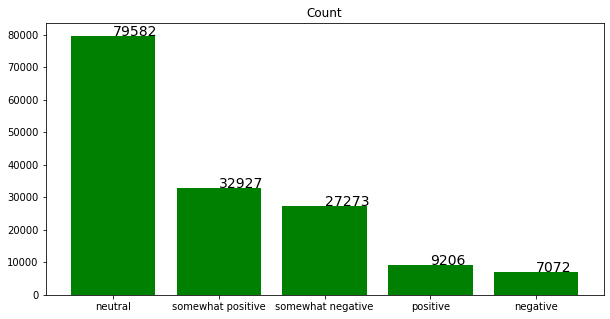

In [243]:
Idx = [1, 2, 3, 4, 5]
plt.figure(figsize = (10,5))
plt.bar(Idx, word_count)
plt.xticks(Idx, ['neutral','somewhat positive','somewhat negative','positive','negative'])
plt.title('Count')
plt.bar(Idx, word_count, color='green')
for a,b in zip(Idx, word_count):
    plt.text(a, b, str(b), color = 'black', fontsize=14)

## Data Preprocessing

In [244]:
lemmatizer = WordNetLemmatizer()

In [245]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [246]:
def text_processing(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub("[^a-zA-Z]"," ", text)
    words = text.split()
    stops = list(stopwords.words("english"))
    stops.remove('no')
    stops.remove('not')
    stops.remove('nor')
    words = [w for w in words if not w in set(stops)]
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    
    if(len(words)==0):
        return 'Null'
    else:
        return (' '.join(words))

In [247]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [248]:
train_data.Phrase = train_data.Phrase.apply(lambda x: text_processing(x))
test_data.Phrase = test_data.Phrase.apply(lambda x: text_processing(x))

In [249]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,series escapade demonstrate adage good goose a...,1,somewhat negative
1,2,1,series escapade demonstrate adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,Null,2,neutral
4,5,1,series,2,neutral


In [250]:
train_data.to_csv("Data/Processed_train.tsv", columns = list(train_data.columns), index = False, sep = '\t')
test_data.to_csv("Data/Processed_test.tsv", columns = list(test_data.columns), index = False, sep = '\t')

## Data Visualization with WordCloud

In [195]:
words = ' '.join(train_data['Phrase'])
words = ' '.join([word for word in words.split()])

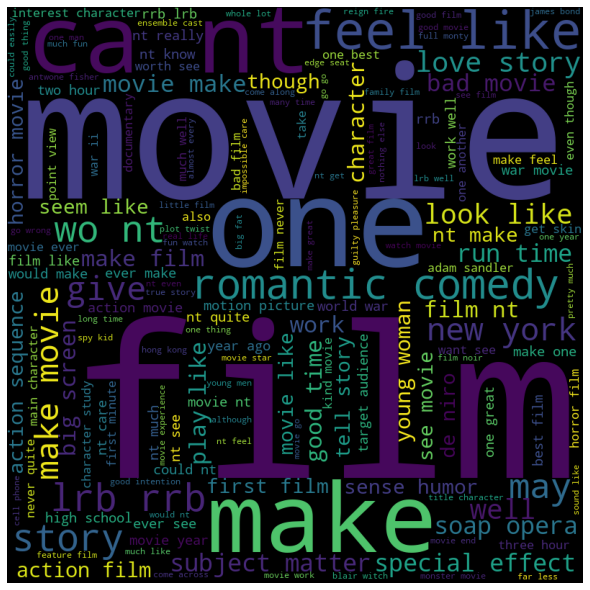

In [196]:
stops = set(stopwords.words("english"))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stops, 
                min_font_size = 10).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.savefig('movie_review_wordcloud.png')
plt.show()

## Data Tokenization and Formatting

In [197]:
train_data = pd.read_csv("Data/Processed_train.tsv", sep = '\t')
test_data = pd.read_csv("Data/Processed_test.tsv", sep = '\t')

In [201]:
vocab_size = 10000
max_len = 125

data = list(train_data.Phrase)
data.append(list(test_data.Phrase))
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
with open('Saved Models/tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

AttributeError: 'float' object has no attribute 'lower'

In [200]:
with open('Saved Models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


def tokenize_data(data):
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, maxlen=max_len)
    return data

In [156]:
def format_data(training_data, test_data, vocab_size, max_len):
    train_X = training_data['Phrase']
    train_Y = to_categorical(training_data['Sentiment'].values)
    test_X = test_data['Phrase']

    train_X = tokenize_data(train_X)
    test_X = tokenize_data(test_X)
    return train_X, train_Y, test_X

In [157]:
train_X, train_Y, test_X = format_data(train_data, test_data, vocab_size, max_len)
# train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.25)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0, 11],
       [ 0,  0,  0, ...,  0,  0,  5]], dtype=int32)

## Model Definition and Training

In [158]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 3,092,253
Trainable params: 3,092,253
Non-trainable params: 0
_________________________________________________________________


In [159]:
epochs = 1
batch_size = 128
early_stopping_monitor = 'accuracy'
weight_filepath = 'Saved Models/weights_Keras_300.hdf5'

checkpoint = ModelCheckpoint(
    weight_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor=early_stopping_monitor, patience = 2)

callbacks_list = [checkpoint, early_stopping]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights(weight_filepath)
# history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=callbacks_list)
history = model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=callbacks_list)


ValueError: Data cardinality is ambiguous:
  x sizes: 703
  y sizes: 156060
Please provide data which shares the same first dimension.

dict_keys(['loss', 'accuracy'])


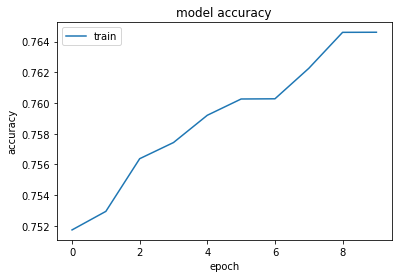

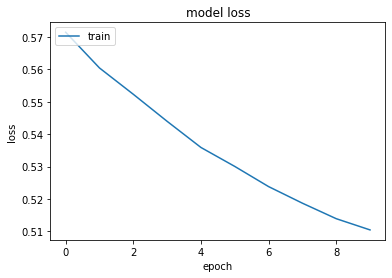

In [54]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(test_X.shape)
weight_filepath1 = 'weights.hdf5'
model.load_weights(weight_filepath1)
review = "the movie was very very fantastic"
processed_review = [text_processing(review)]
tokenized_review = tokenize_data(processed_review[0:1])
sentiment = model.predict_classes(tokenized_review)
print(sentiment)

In [56]:
print(test_X.shape)

(65595, 125)


In [55]:
#make the predictions with trained model and submit the predictions.

y_pred=model.predict_classes(test_X)

sub_file = pd.read_csv('Data/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


ValueError: Length of values (65595) does not match length of index (66292)